<img src='images/pic1.jpg'/>

<h1> 5. Assignments </h1>

<ol>
    <li> Use bag of words upto 4 grams and compute the micro f1 score with Logistic regression(OvR) </li>
    <li> Perform hyperparam tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch  </li>
    <li> Try OneVsRestClassifier  with Linear-SVM (SGDClassifier with loss-hinge)</li>
</ol>

In [0]:
#Taking 0.5 Million entries to a dataframe.
conn_r = sqlite3.connect('Copy of Titlemoreweight.db')
preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.close()

In [0]:
preprocessed_data=preprocessed_data[:100000]

In [9]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [10]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 100000
number of dimensions : 2


In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [0]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

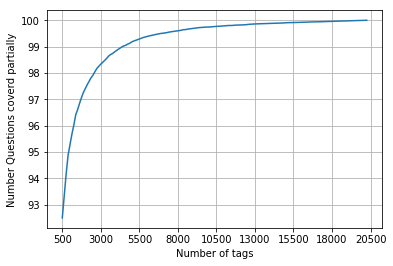

with  5500 tags we are covering  99.481 % of questions
with  500 tags we are covering  92.5 % of questions


In [14]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [15]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 7500 out of  100000


In [0]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [17]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (80000, 500)
Number of data points in test data : (20000, 500)


<h3>Featurizing data with count vectorizer(BoW)

In [18]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000, tokenizer=lambda x: x.split(), ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:23.851951


In [19]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (80000, 101734) Y : (80000, 500)
Dimensions of test data X: (20000, 101734) Y: (20000, 500)


<h3>log regg one vs rest classifier and hyper param tunning

In [21]:
from sklearn.model_selection import GridSearchCV
param={'estimator__alpha': [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}
classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'))
gsv = GridSearchCV(estimator = classifier, param_grid=param, cv=3, verbose=0, scoring='f1_micro',n_jobs=15)
gsv.fit(x_train_multilabel, y_train)

best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
print('value of alpha after hyperparameter tuning : ',best_alpha)

value of alpha after hyperparameter tuning :  0.001


<h3>Training a classifier with the best value of the hyperparameter 

In [22]:
start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=best_alpha, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.1197
Hamming loss  0.0040428
Micro-average quality numbers
Precision: 0.4430, Recall: 0.3065, F1-measure: 0.3624
Macro-average quality numbers
Precision: 0.3185, Recall: 0.2214, F1-measure: 0.2374
Time taken to run this cell : 0:03:44.962072


<h3>Support Vector Classification(SGD Classifier with hinge loss) 

<h3>hyper param

In [23]:
param={'estimator__alpha': [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1'))
gsv = GridSearchCV(estimator = classifier, param_grid=param, cv=3, verbose=0, scoring='f1_micro',n_jobs=15)
gsv.fit(x_train_multilabel, y_train)

best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
print('value of alpha after hyperparameter tuning : ',best_alpha)

value of alpha after hyperparameter tuning :  0.001


<h3>model with best hyper param

In [24]:
start = datetime.now()
#best_alpha = gsv.best_estimator_.get_params()['estimator__alpha']
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=best_alpha, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.1168
Hamming loss  0.004063
Micro-average quality numbers
Precision: 0.4389, Recall: 0.3027, F1-measure: 0.3583
Macro-average quality numbers
Precision: 0.2867, Recall: 0.2268, F1-measure: 0.2271
Time taken to run this cell : 0:02:44.301788



<h1>Conclusion</h1>

    We have choosen 'f1_micro' scoring metric because of the stated business statement.

    Used bag of words upto 4 grams 

    For logistic regression , I have used 'SGDClassifier' instead of 'LogisticRegression'. The reason is 'LogisticRegression' takes lots of time for hyperparameter tuning.



In [26]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Classification model", "featurization","micro-f1","macro-f1","hamming loss ","accuracy"]

x.add_row(["log reg(sgd classifier)", 'count vec', 0.36, 0.23, 0.004,0.119])
x.add_row(["linear svm", 'count vec', 0.35, 0.22, 0.004,0.116])

print(x)

+-------------------------+---------------+----------+----------+---------------+----------+
|   Classification model  | featurization | micro-f1 | macro-f1 | hamming loss  | accuracy |
+-------------------------+---------------+----------+----------+---------------+----------+
| log reg(sgd classifier) |   count vec   |   0.36   |   0.23   |     0.004     |  0.119   |
|        linear svm       |   count vec   |   0.35   |   0.22   |     0.004     |  0.116   |
+-------------------------+---------------+----------+----------+---------------+----------+
